# Mash based clustering of the dataset

In [43]:
import pandas as pd
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

#import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import squareform, pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import numpy as np
import networkx as nx
import plotly.graph_objects as go
import yaml
import matplotlib.patches as mpatches
from sklearn.metrics import silhouette_samples, silhouette_score

sns.set_context("paper")

In [44]:
with open("config.yaml", "r") as f:
    notebook_configuration = yaml.safe_load(f)
notebook_configuration

{'bgcflow_dir': '/datadrive/bgcflow'}

In [50]:
# Write samples.csv table to config directory of qc_strepto_ncbi project
bgcflow_dir = Path(notebook_configuration["bgcflow_dir"])
project_name_1 = "mq_strepto"
processed_dir_1 = bgcflow_dir / "data" / "processed" / project_name_1

# Read output tables from the processed directory
ncbi_meta_table = processed_dir_1 / "tables"/ "df_ncbi_meta.csv"
df_ncbi_meta = pd.read_csv(ncbi_meta_table, index_col= 0)

gtdb_meta_table = processed_dir_1 / "tables"/ "df_gtdb_meta_curated.csv"
df_gtdb_meta = pd.read_csv(gtdb_meta_table, index_col= 0)

seqfu_meta_table = processed_dir_1 / "tables"/ "df_seqfu_stats.csv"
df_seqfu_meta = pd.read_csv(seqfu_meta_table, index_col= 0)

mash_table = processed_dir_1 / "mash"/ "df_mash.csv"
df_mash = pd.read_csv(mash_table, index_col= 0)

filters_table = processed_dir_1 / "tables" / "df_filters.csv"
df_filter_quality = pd.read_csv(filters_table, index_col=0)

In [51]:
df_mash_original = df_mash.copy()

# 1. Remove duplicate genomes

Use the selected genomes used in the autoMLST tree building process

In [52]:
df_mldist = pd.read_csv("/datadrive/bgcflow/data/processed/mq_strepto/automlst_wrapper/raxmlpart.txt.mldist")
representative_genomes = []

for idx in df_mldist.iloc[:,0]:
    genome_id = idx.split(" ")[0]
    if genome_id.startswith("GCF_"):
        genome_id_corrected = genome_id[:-1] + "." + genome_id[-1]
    else:
        genome_id_corrected = genome_id
    if genome_id_corrected in df_mash.index:
        representative_genomes.append(genome_id_corrected)

# 2. Clustering of MASH with optimal K-means

In [53]:
def kMeansRes(scaled_data, k, alpha_k=0.02):
    '''
    # Calculating clusters from https://medium.com/towards-data-science/an-approach-for-choosing-number-of-clusters-for-k-means-c28e614ecb2c
    Parameters 
    ----------
    scaled_data: matrix 
        scaled data. rows are samples and columns are features for clustering
    k: int
        current k for applying KMeans
    alpha_k: float
        manually tuned factor that gives penalty to the number of clusters
    Returns 
    -------
    scaled_inertia: float
        scaled inertia value for current k           
    '''
    
    inertia_o = np.square((scaled_data - scaled_data.mean(axis=0))).sum()
    # fit k-means
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_data)
    scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
    return scaled_inertia

def chooseBestKforKMeans(scaled_data, k_range):
    ans = []
    for k in k_range:
        scaled_inertia = kMeansRes(scaled_data, k)
        ans.append((k, scaled_inertia))
    results = pd.DataFrame(ans, columns = ['k','Scaled Inertia']).set_index('k')
    best_k = results.idxmin()[0]
    return best_k, results

Estimated number of clusters: 6


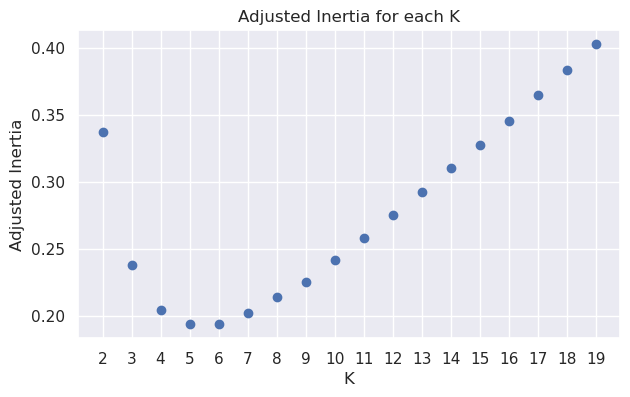

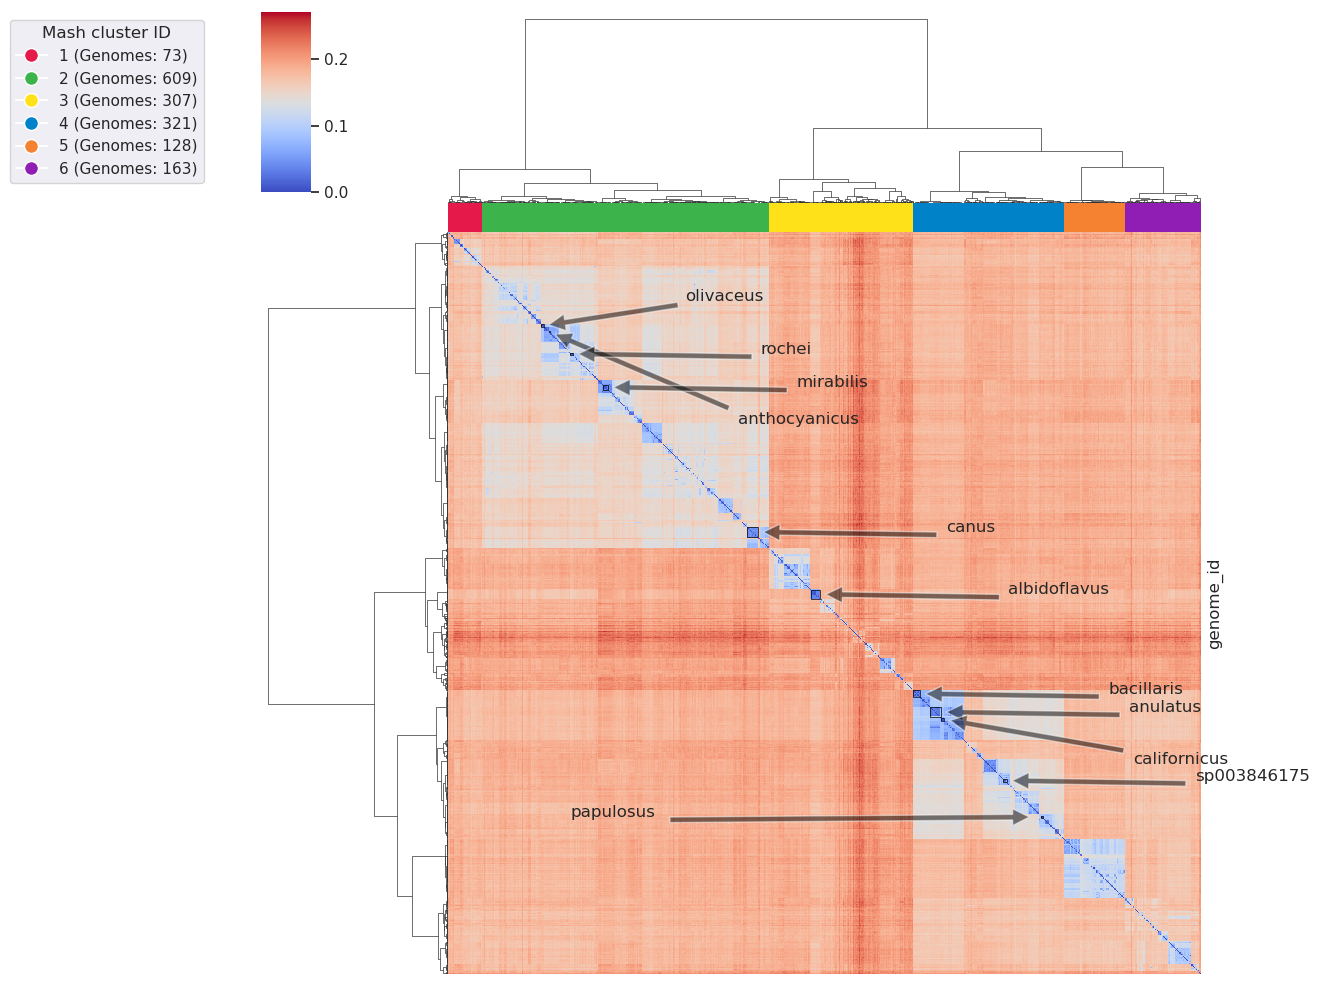

In [55]:
# Subtracting Mash distances from 1 to convert to similarity
df_mash = df_mash_original.loc[representative_genomes, representative_genomes]
df_similarity = 1 - df_mash

# Computing pairwise distances using Pearson's correlation coefficient
distances = squareform(pdist(df_similarity, metric='correlation'))

# Performing hierarchical clustering using ward.D2 method
linkage_matrix = linkage(distances, method='ward')

# Reordering rows and columns of the distance matrix based on clustering
ordered_indices = dendrogram(linkage_matrix, no_plot=True)['leaves']
df_reordered = df_similarity.iloc[ordered_indices, ordered_indices]

# choose k range
if len(df_mash) <= 21:
    max_range = len(df_mash) - 1
else:
    max_range = 20

k_range=range(2, max_range)
# compute adjusted intertia
best_k, results = chooseBestKforKMeans(distances, k_range)

# plot the results
plt.figure(figsize=(7,4))
plt.plot(results,'o')
plt.title('Adjusted Inertia for each K')
plt.xlabel('K')
plt.ylabel('Adjusted Inertia')
plt.xticks(range(2,max_range,1))
print(f"Estimated number of clusters: {best_k}")
plt.savefig("assets/figures/Figure_2/kmeans_plot_reduced.png")
# plt.savefig("assets/figures/Figure_2/kmeans_plot.svg")
plt.show()

# Cluster using best k-means
n_clusters = best_k

# max color 12
if best_k < 12:
    top_clusters = best_k
else:
    top_clusters = 12

# Use fcluster to assign cluster labels
clusters = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

# Create dataframe assigning genomes to clusters
df_mash_clusters_kmeans = pd.DataFrame({'Cluster': clusters}, index=df_similarity.index)

# Define the colors for 15 detected clusters
color_set_15 = ["#e6194b", "#3cb44b", "#ffe119", "#0082c8", "#f58231", "#911eb4", "#46f0f0", "#f032e6", "#d2f53c", "#fabebe", "#008080", "#e6beff", "#aa6e28", "#fffac8", "#800000"]
cluster_list = sorted(df_mash_clusters_kmeans.Cluster.unique())
cluster_color_dict = dict(zip(cluster_list, color_set_15))

# Update df_mash_clusters
df_mash_clusters_kmeans["Cluster_Color"] = [cluster_color_dict[df_mash_clusters_kmeans.loc[genome_id, "Cluster"]] for genome_id in df_mash_clusters_kmeans.index]
df_mash_clusters_kmeans["Species"] = df_gtdb_meta.loc[df_mash_clusters_kmeans.index,"Species"]
df_mash_clusters_kmeans = df_mash_clusters_kmeans.loc[df_reordered.index, :]

df_mash_clusters_kmeans.to_csv("assets/tables/df_mash_clusters_kmeans_nonredundant.csv")

# Plotting the clustermap below the dendrogram
col_colors = [cluster_color_dict[df_mash_clusters_kmeans.loc[genome_id, "Cluster"]] for genome_id in df_mash.index]
sns.set(font_scale=1.0)  # Adjust font size for row labels
g = sns.clustermap(df_mash, cmap='coolwarm', 
                   row_linkage=linkage_matrix, col_linkage=linkage_matrix, 
                   col_colors= col_colors,
                   xticklabels=False, yticklabels=False)

# Create a color legend with unique cluster colors
color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_color_dict[cluster],
                           markersize=10) for cluster in sorted(cluster_list)]

cluster_sizes = df_mash_clusters_kmeans.Cluster.value_counts()
labels = [f"{cluster} (Genomes: {cluster_sizes[cluster]})" for cluster in sorted(cluster_list)]

# Add color legend
plt.legend(color_legend, labels, title='Mash cluster ID', bbox_to_anchor=(-1, 1))

# Highlighting square
from matplotlib.patches import Rectangle

species_list = ["albidoflavus", "anulatus", "olivaceus", "bacillaris", "canus", "sp003846175", 
                "papulosus", "anthocyanicus", "californicus", "mirabilis", "rochei"]
for selected_species in species_list:
    x_min = 0 
    y_min = 0 
    xy_size = 0
    
    for idx in range(df_mash_clusters_kmeans.shape[0]):
        if selected_species == df_mash_clusters_kmeans.iloc[idx, 2]:
            xy_size = xy_size + 1
            if x_min == 0:
                x_min = idx
                y_min = idx      
    
    highlight = Rectangle((x_min, y_min), xy_size, xy_size, fill=False, edgecolor='black', lw=0.5)  # square with lower-left corner at (0,0), width and height 2
    g.ax_heatmap.add_patch(highlight)
    g.ax_heatmap.plot()  # Refresh the plot
    
    # Adding text label
    if selected_species == "olivaceus":
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size, y_min+xy_size/2), xytext=(x_min+xy_size+300, y_min-50),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5))
    elif selected_species == "anthocyanicus":
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size, y_min+xy_size/2), xytext=(x_min+xy_size+400, y_min+200),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5))
    elif selected_species == "californicus":
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size, y_min+xy_size/2), xytext=(x_min+xy_size+400, y_min+100),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5))
    elif selected_species == "parvus":
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size, y_min+xy_size/2), xytext=(x_min+xy_size+400, y_min+200),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5))
    elif x_min > 1200:
        g.ax_heatmap.annotate(selected_species, xy=(x_min, y_min+xy_size/2), xytext=(x_min-1000, y_min+xy_size/2),
                     arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5))
    else:
        g.ax_heatmap.annotate(selected_species, xy=(x_min+xy_size, y_min+xy_size/2), xytext=(x_min+xy_size+400, y_min+xy_size/2),
                 arrowprops=dict(facecolor='black', shrink=0.03, alpha=0.5))

plt.savefig("assets/figures/Figure_2/mash_kmeans_nonredundant.png")
plt.show()

## Silhouette coefficient assessment

Assess the above clustering using the silhouette coefficient for each of the detected clusters

In [56]:
from sklearn.metrics import silhouette_samples, silhouette_score

df_clusters = df_mash_clusters_kmeans.loc[df_similarity.index,:]
# Compute silhouette coefficient for each sample
silhouette_values = silhouette_samples(distances, clusters)

# Calculate average silhouette coefficient for each cluster
cluster_silhouette_scores = []
for cluster in sorted(df_clusters['Cluster'].unique()):
    cluster_samples = df_clusters['Cluster'] == cluster
    average_silhouette_score = silhouette_values[cluster_samples].sum() / len(silhouette_values[cluster_samples])
    cluster_silhouette_scores.append((cluster, average_silhouette_score))

# Print the average silhouette coefficient for each cluster
for cluster, score in cluster_silhouette_scores:
    print(f"Cluster {cluster}: {score}")

Cluster 1: 0.5728768111124498
Cluster 2: 0.654592303769709
Cluster 3: 0.38517690417420497
Cluster 4: 0.6170298734583602
Cluster 5: 0.8629690442969276
Cluster 6: 0.5264829754750449


In [57]:
df_clusters["Silhouette"] = silhouette_values
df_silhouette = df_clusters.copy()

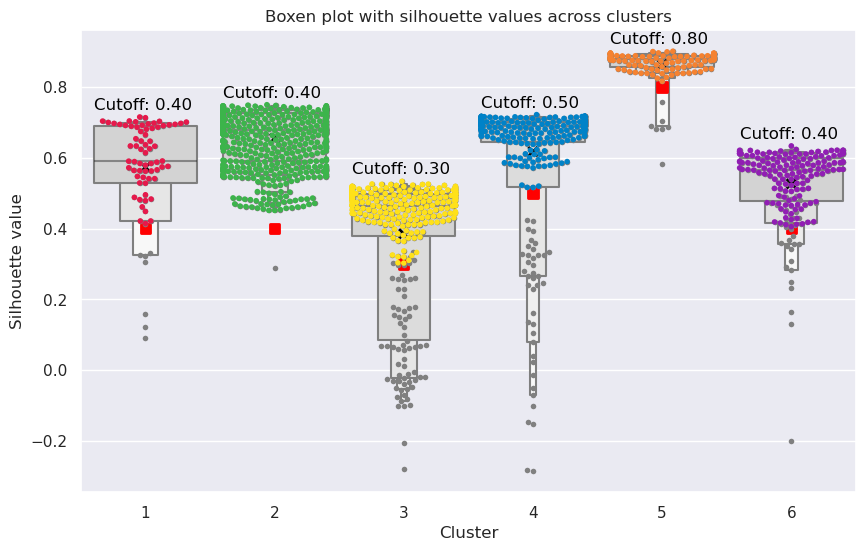

In [59]:
# Filter the DataFrame to keep only the samples with silhouette scores greater than the threshold
threshold = -1
df_silhouette_filtered = df_silhouette[df_silhouette['Silhouette'] > threshold]

data = df_silhouette_filtered.copy()
# Define the quantiles to restrict the plot for each category
lower_cutoffs = {1:0.4, 2:0.4, 3:0.3, 4:0.5, 5:0.8, 6:0.4}

# Create an empty list to store the filtered data for each category
filtered_data_list = []

color_map = {'1': '#e6194b',
 '2': '#3cb44b',
 '3': '#ffe119',
 '4': '#0082c8',
 '5': '#f58231',
 '6': '#911eb4'}

# Iterate through each category and filter the data based on the quantiles
for category in sorted(data['Cluster'].unique()):
    category_data = data[data['Cluster'] == category]
    cutoff_value = lower_cutoffs[category]
    filtered_category_data = category_data[category_data['Silhouette'] >= cutoff_value]
    filtered_data_list.append(filtered_category_data)
    
# Concatenate the filtered data for all categories
filtered_data = pd.concat(filtered_data_list)

# Create the boxenplot using the filtered data
plt.figure(figsize=(10, 6))
sns.boxenplot(x='Cluster', y='Silhouette', data=data, color='lightgray', showfliers=False)
sns.swarmplot(x='Cluster', y='Silhouette', data=data, size=4, color="grey")
sns.swarmplot(x='Cluster', y='Silhouette', data=filtered_data, size=4, palette=color_map)
sns.pointplot(x='Cluster', y='Silhouette', data=data, color='black', markers='x', join=False, ci=None)
sns.pointplot(x='Cluster', y='Silhouette', data=pd.DataFrame(list(lower_cutoffs.items()), columns=['Cluster', 'Silhouette']),
              color='red', markers='s', join=False, ci=None)
plt.title('Boxen plot with silhouette values across clusters')
plt.xlabel('Cluster')
plt.ylabel('Silhouette value')

# # Plot the chosen lower cutoff values
for category, value in lower_cutoffs.items():
    category_data = data[data['Cluster'] == category]
    plt.text(category - 1.4, category_data.Silhouette.max() + 0.02, f'Cutoff: {value:.2f}', color='black')

# Show the plot
plt.savefig("assets/figures/Figure_2/silhouette_non_redundant.png")
plt.show()